# **JuliaPanel**

In [5]:
include("Modules/aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

LoadError: syntax: extra token "PyPlot" after end of expression

## Fundamental Solutions

In [6]:
x_domain, y_domain = (-2, 2), (-1, 1)
source_strength = 1.0
sink_strength = -1.5
kappa = 1.0
x_source, y_source = 0.0, 0.0
x_sink, y_sink = 1.0, 0.0
uniform_mag = 1.0
uniform_ang = 0.0
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size)
R = sqrt(kappa/(2π*uniform_mag));

In [7]:
sourcerer = panelSolver.Source2D(source_strength, x_source, y_source)
uniformer = panelSolver.Uniform2D(uniform_mag, uniform_ang)
doublet = panelSolver.Doublet2D(kappa, x_source, y_source)
# doublet.velocity.(X, Y)
vels = [ a .+ b for (a, b) in zip(uniformer.velocity.(X, Y), doublet.velocity.(X, Y)) ]
pots = uniformer.potential.(X, Y) .+ doublet.potential.(X, Y);
streams = uniformer.stream.(X, Y) .+ doublet.stream.(X, Y);
# vels, pots = panelSolver.gridData([uniformer, doublet], zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniformer.magnitude);

In [ ]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, [ u for (u, v) in vels ], [ v for (u,v) in vels ], density=2)
contourf(X, Y, cp, levels=range(x_domain[1], stop=x_domain[end], length=100), extend="both", cmap=PyPlot.cm.rainbow)
colorbar(label="\$\\phi_{\\mathrm{source}}\$")
contour(X, Y, streams, levels=[0.], colors="#CD2305", linewidths=2, linestyles="solid")
circle = plt.Circle((0, 0), radius=R, color="#CD2305", alpha=0.5)
gca().add_patch(circle)
xlim(x_domain)
ylim(y_domain)
tight_layout();

## Panel Methods

#### Source Panels

In [ ]:
x_domain, y_domain = (-3, 3), (-2, 2)
grid_size = 50
x_dom, y_dom = range(x_domain[1], stop=x_domain[2], length=grid_size), range(y_domain[1], stop=y_domain[2], length=grid_size)
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

r = 1
N_panels = 20
theta = range(0.0, stop=2π, length=N_panels + 1)
x_center, y_center = 0.0, 0.0
x_cylinder, y_cylinder = (x_center .+ r*cos.(theta), y_center .+ r*sin.(theta))
x_ends = r*cos.(theta)
y_ends = r*sin.(theta)
uniform_mag = 1.0
uniform_ang = 0.0

uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang)
source_panels = [ panelSolver.SourcePanel2D(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1]) for i in 1:N_panels ];
cylinder = panelSolver.SourcePanelSolver2D(source_panels, uniform);

In [ ]:
@time strengths, vts, error = panelSolver.panelSolver2D(cylinder, uniform);
vels, pots = panelSolver.gridData(cylinder, zip(X,Y))
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);

In [ ]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
xlabel("\$x\$")
ylabel("\$C_p\$")
# plot(x_cylinder, cp_anal, label="Analytical")
scatter([p.xc for p in source_panels if p.loc == "upper"], [p.cp for p in source_panels if p.loc == "upper" ], marker=".", label="Upper")
scatter([p.xc for p in source_panels if p.loc == "lower"], [p.cp for p in source_panels if p.loc == "lower" ], marker="d", label="Lower")
tight_layout()
legend();

In [ ]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.15width, height), dpi=300)
streamplot(X, Y, [ u for (u,v) in vels ], [ v for (u,v) in vels ], density=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], marker=".", label="Endpoints", color="orange", zorder=3)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="black", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
plt.plot(x_cylinder, y_cylinder, label="Cylinder", color="b", linestyle="--", linewidth=1)
plot(x_ends, y_ends, label="Panels", color="orange", linestyle="-", linewidth=2)
scatter([p.xs for p in source_panels], [p.ys for p in source_panels], label="Endpoints", color="orange", s=40)
scatter([p.xc for p in source_panels], [p.yc for p in source_panels], label="Center-points", color="w", s=40, zorder=3)
fill(x_ends, y_ends, color="k", zorder=3)
title("Number of Source Panels: {$N_panels}")
tight_layout();

#### Doublet-Source Panels

In [ ]:
include("Modules/aeroModules.jl")
using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

In [ ]:
coords = open("../CAVFOIL/coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end

N_panels = 80
xs, ys = panelSolver.NACA4((0,0,1,5), 1.0, N_panels, true)
coords = zip(xs, ys)
# [ print(coord) for coord in coords ]

x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("../CAVFOIL/coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

x_ends, y_ends = reverse(x_ends), reverse(y_ends)

uniform_mag, uniform_ang = 1.0, 5.0
panels = [ panelSolver.DoubletSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);
print(panels[1].length, " ", panels[end].length, '\n')
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
airfoil = panelSolver.DoubletSourcePanelSolver2D(panels, uniform);

In [ ]:
@time strengths, vts, cl, error = panelSolver.panelSolver2D(airfoil, uniform);
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));
cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# print([ panel.source_strength for panel in panels ])
print("Lift Coefficient: ", cl, "\n")
print("Error: ", error)

In [ ]:
figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.xs for panel in panels ], [ panel.ys for panel in panels ], linestyle="-", linewidth=1, marker=".", markersize=5, color="#CD2305")
axis("scaled", adjustable="box")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

In [ ]:
fig20 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend();

In [ ]:
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig1 = figure(1, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([p.xs for p in panels], [p.ys for p in panels], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();

In [ ]:
coords = open("../CavFoil/coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end

N_panels = 80
xs, ys = panelSolver.NACA4((0,0,1,5), 1.0, N_panels, true)
coords = zip(xs, ys)
# [ print(coord) for coord in coords ]

x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("../CavFoil/coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

x_ends, y_ends = reverse(x_ends), reverse(y_ends)

uniform_mag, uniform_ang = 1.0, 5.0
panels = [ panelSolver.VortexSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);
print(panels[1].length, " ", panels[end].length, '\n')
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
airfoil = panelSolver.vortexSourcePanelSolver2D(panels, uniform);

In [ ]:
@time strengths, vts, cl, error = panelSolver.vortexSourcePanelSolver2D(panels, uniform);
# vels, pots = panelSolver.gridData(airfoil, zip(X,Y));
# cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# print([ panel.source_strength for panel in panels ])
print("Lift Coefficient: ", cl, "\n")
print("Error: ", error)

## Multiple Dispatch

In [2]:
include("Modules/functionalPanel.jl")
# include("Modules/aeroModules.jl")

using .AeroModules
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

# Grid parameters
x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

# Diamond wedge test
# panels = [ AeroModules.DoubletPanel2D((1.0, 0.0), (0.5, -0.1)), AeroModules.DoubletPanel2D((0.5, -0.1), (0.0, 0.0)), AeroModules.DoubletPanel2D((0.0, 0.0), (0.5, 0.1)), AeroModules.DoubletPanel2D((0.5, 0.1), (1.0, 0.0)) ]
N_panels = 160
coords = open("coordinates/ClarkY.dat") do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end
x_ends, y_ends = AeroModules.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

cosine = open("coordinates/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end
x_ends, y_ends = reverse(x_ends), reverse(y_ends)

panels = [ AeroModules.DoubletPanel2D((xs, ys), (xe, ye)) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];

uniform = AeroModules.Uniform2D(5.0, 5.0)

@time (cl, kcl, cps) = AeroModules.aeroCoefficients(panels, uniform)
println("Lift Coefficient: $cl, $kcl")
# println("Pressure Coefficients: $cps")

# For plotting purposes
vels, pots = panelSolver.gridData(airfoil, zip(X,Y));

# Pressure coefficients
cp = panelSolver.pressureCoefficient2D(vels, uniform.mag);
# print([ panel.source_strength for panel in panels ])

  1.270485 seconds (4.65 M allocations: 234.113 MiB, 11.11% gc time)
Lift Coefficient: 1.1441850967551215, 1.0007629649508119


In [3]:
# Airfoil plotter
fig1 = figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords ], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.start[1] for panel in panels ], [ panel.start[2] for panel in panels ], linestyle="-", linewidth=0.5, marker=".", markersize=3, color="#CD2305")
axis("scaled", adjustable="box")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

# Plot pressure coefficient
fig2 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend()
show()

# Plot flowfield
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig3 = figure(3, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
# fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([ panel.start[1] for panel in panels ], [ panel.start[2] for panel in panels ], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();

ErrorException: type DoubletPanel2D has no field loc

## OOP

In [4]:
include("Modules/doubletSourcePanelSolver.jl")
# using .panelSolver
using BenchmarkTools
using PyPlot
using PyCall
jtplot = pyimport("jupyterthemes.jtplot")
jtplot.style(grid=false)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = true

# Grid parameters
x_domain, y_domain = (-1, 2), (-1, 1)
grid_size = 50
x_dom, y_dom = range(x_domain[1], length=grid_size, stop=x_domain[2]), range(y_domain[1], length=grid_size, stop=y_domain[2])
X = repeat(x_dom', grid_size)
Y = repeat(y_dom, 1, grid_size);

# Import airfoil coordinates file
N_panels = 121
filename = "coordinates/ClarkY.dat"
coords = open(filename) do f 
    [ Tuple(parse.(Float64,(split(line)))) for line in eachline(f) ] 
    end
# x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

# Generate NACA airfoil coordinates
N_panels = 100
xs, ys = panelSolver.NACA4((2,4,1,2), 1.0, N_panels, true)
coords = zip(xs, ys)
x_ends, y_ends = panelSolver.cosineAirfoil([ x for (x, y) in coords ], [ y for (x, y) in coords ], N_panels)

# Generate flat plate coordinates
# coords = zip(reverse(range(0, 1, length=10)), zeros(10));
# x_ends, y_ends = panelSolver.cosinePanels([ x for (x, y) in coords ], [ y for (x, y) in coords], 30);

# Save cosine-distribution interpolated points
cosine = open("Modules/cosinepanels.dat", "w") do f
    [ write(f, "$x $y \n") for (x, y) in zip(x_ends, y_ends) ]
end

# File coordinates
# x_ends, y_ends = [ x for (x, y) in coords ], [ y for (x, y) in coords ]

# Reverse coordinates to follow clockwise convention
x_ends, y_ends = reverse(x_ends), reverse(y_ends)

# Using airfoil panels
panels = [ panelSolver.DoubletSourcePanel2D(xs, ys, xe, ye) for (xs, xe, ys, ye) in zip(x_ends[1:end-1], x_ends[2:end], y_ends[1:end-1], y_ends[2:end]) ];

# Diamond wedge test case
# panels = [ panelSolver.DoubletSourcePanel2D(1.0, 0.0, 0.5, -0.1), panelSolver.DoubletSourcePanel2D(0.5, -0.1, 0.0, 0.0), panelSolver.DoubletSourcePanel2D(0.0, 0.0, 0.5, 0.1), panelSolver.DoubletSourcePanel2D(0.5, 0.1, 1.0, 0.0) ]

# Hexagon
# panels = [ panelSolver.DoubletSourcePanel2D(1.0, 0.0, 0.75, -0.1), panelSolver.DoubletSourcePanel2D(0.75, -0.1, 0.25, -0.1), panelSolver.DoubletSourcePanel2D(0.25, -0.1, 0.0, 0.0), panelSolver.DoubletSourcePanel2D(0.0, 0.0, 0.25, 0.1), panelSolver.DoubletSourcePanel2D(0.25, 0.1, 0.75, 0.1), panelSolver.DoubletSourcePanel2D(0.75, 0.1, 1.0, 0.0) ]

# Uniform2D construction
uniform_mag, uniform_ang = 5.0, 5.0
uniform = panelSolver.Uniform2D(uniform_mag, uniform_ang);


# Print panel attributes
# [ print("Start: ", (panel.xs, panel.ys), ", End: ", (panel.xe, panel.ye), '\n', "Normal: ", panel.normal, ", Tangent: ", panel.tangent, ", Angle: ", rad2deg(panel.angle), ", Position: ", panel.loc, '\n') for panel in panels]
# print(panels[1].length, " ", panels[end].length, '\n')

# Solve system
@time airfoil, strengths, cps, cl, error = panelSolver.panelSolver2D(panels, uniform, false, true);

# # For plotting purposes
# vels, pots = panelSolver.gridData(airfoil, zip(X,Y));

# # Pressure coefficients
# cp = panelSolver.pressureCoefficient2D(vels, uniform.magnitude);
# # print([ panel.source_strength for panel in panels ])
println("Lift Coefficient: ", cl)
# # DEBUGGING
# println("Strengths:", strengths)
# println("Pressure Coefficients:", cps)
# println("'Error': ", error)

[0.5 1.871189046855883e-5 2.7014326058974067e-5 3.664768485935638e-5 4.5543250323841355e-5 5.3428489237674194e-5 6.015044355796332e-5 6.561961107115668e-5 6.980599567824855e-5 7.274024172766187e-5 7.451413488885818e-5 7.52793045050402e-5 7.524383050193251e-5 7.46667266850825e-5 7.385041137290005e-5 7.313137853186478e-5 7.286936755252379e-5 7.343540019495963e-5 7.519910771191753e-5 7.851580814593565e-5 8.371381244936129e-5 9.108243861372128e-5 0.00010086119645744295 0.00011323057368694155 0.00012830480799761663 0.00014612697180259318 0.00016666662681564905 0.00018982022593571458 0.0002033266657727985 0.00020242913604796286 0.00020893626191255524 0.00022200972032141084 0.0002406641067441969 0.0002639844887092639 0.0002911268690757484 0.00032132348379650013 0.00035389106615297926 0.00038824044932897223 0.0004238861200388229 0.0004604545956438198 0.0004976907810767972 0.000535461769235611 0.0005737578855790034 0.0006126911910840419 0.0006524923479597443 0.00069350856678725 0.00073621253796

 0.0008427467520819083 0.0008221373891661442 0.0008157258340467834 0.0008115751719514789 0.0008101986988720619 0.000812187345629737 0.0008182437327835238 0.000829246539612287 0.0008463465975100753 0.0008711110061319841 0.0009057424240403076 0.0009534202506017584 0.0010188469465255067 0.0011091537879292475 0.0012354652532191304 0.0014157337245714228 0.001680176075902318 0.002082439381785151 0.002724560738670226 0.0038191373542801705 0.005868120981978084 0.010291586140339565 0.022411422780186614 0.07282303288429953 0.20906036386313395 0.08619139281631565 0.02376828158388188 0.008755259611633067 0.0023709570484224474 0.012214409686295433; 5.372548525912436e-6 1.605442980849805e-5 2.6659519879988905e-5 3.786548999545978e-5 5.8969765170687544e-5 0.5 7.478130056221402e-5 6.552844474905859e-5 6.747084451347983e-5 6.954857543286906e-5 7.089043364130687e-5 7.143164108735322e-5 7.131058859342843e-5 7.07587294258622e-5 7.006569625206277e-5 6.95608912881674e-5 6.959912220130323e-5 7.05471072676910

 0.000706958486748198 0.0007523998520451623 0.0007999532616910342 0.000850396952490326 0.0009054222264972513 0.00116165455015304 0.0007533504020019859 0.0009918842016192165 0.0010071137905453143 0.0010261886470436957 0.0010467849579985009 0.0010678374658464908 0.0010885559237273203 0.0011083065379204095 0.0011265852005426541 0.0011430072936376402 0.0011573007014978555 0.001169298935021863 0.0011789336745625587 0.001186226747565484 0.0011912818070671986 0.0011942760834661675 0.0011954526489434192 0.001195113708413267 0.0011936155443589634 0.001191365926003712 0.0011888250850312825 0.001186531593255653 0.0012102923837155385 0.001258962774525768 0.001321685162548254 0.0014023638701372255 0.001506248821471511 0.001640573528321524 0.0018155857366464287 0.0020462370348199753 0.0023550531658887994 0.0027772198510299414 0.0033700539760046964 0.00423171508997325 0.005540879771603556 0.007648326584828241 0.011310873487489798 0.018359588686721478 0.033741907828171235 0.06929332001142446 0.1131528

-5 7.716778961563312e-5 8.659741551212954e-5 9.864334728874611e-5 0.00011347173239799997 0.00013120396908237366 0.00015190038477401742 0.00017555240934027168 0.00020207958690935906 0.0002313302962652422 0.000245565400277208 0.00023950726689934529 0.0002450345747858788 0.00026006067562861913 0.00028267050039703853 0.0003113068129193188 0.0003446819814347254 0.0003817258960124986 0.0004215564990485226 0.0004634642175510557 0.0005069045180238358 0.0005514946903429032 0.0005970122600742386 0.0006433933804186769 0.0006907303197954288 0.0007392678847413546 0.0007893996028993726 0.000841666821207236 0.0008967728326701276 0.0009556760829803845 0.0010203794422839721 0.0013136406173228146 0.0008552285791316839 0.0011302297267263384 0.001153397099469643 0.001182063609607269 0.001213735956530159 0.001247372397080612 0.0012822710374502525 0.0013179395398027355 0.00135407095203133 0.001390540900246072 0.001427411615359896 0.0014649401524328921 0.0015035912550381036 0.0015440566616427207 0.0015872837

 0.0018885122013916292 0.0014669575034036515 0.0010961764429957804 0.0007604615821843773 0.00044766348439292155 0.00014782380406357538 0.011241627452900495; 3.4643017242759353e-6 1.0306796426019361e-5 1.6896964038044813e-5 2.308378563881844e-5 2.8740405510985233e-5 3.377258089128512e-5 3.812600343332894e-5 4.179223049508309e-5 4.481301762725302e-5 4.7282926083627514e-5 4.9350214823055076e-5 5.121627637231515e-5 5.313441409456933e-5 5.541014152654125e-5 5.8409459959702226e-5 6.259781292069164e-5 6.871323007245195e-5 7.879524422432306e-5 0.0001117001561876904 0.5 0.00013641361300894831 0.0001278401697327297 0.00014347433119122564 0.0001645263370637025 0.000189325581491796 0.00021744404996388873 0.00024864323552592537 0.00028269111887561005 0.00029361053259369585 0.0002770163634043242 0.0002796136637022583 0.0002962081149778518 0.000323018071440881 0.00035739695970714893 0.00039741433140035037 0.0004416246767096838 0.0004889375501407511 0.0005385441508391622 0.0005898758593205992 0.000642

 0.007324331631920543 0.008867895404047817 0.011011745370735971 0.014061012716875638 0.018534550514788365 0.025014735575581745 0.03379325649189765 0.04357186578605205 0.049762490382412226 0.047594135594176475 0.03886512105655729 0.029146072952206892 0.021384892234184813 0.015855845749751536 0.0120156714062339 0.009322052247060014 0.007389593618893096 0.00596653706728442 0.004890788475394233 0.004056897019343933 0.0033949072666615756 0.0028573577239077133 0.0024113086398939313 0.0020333927675039456 0.0017066850277341317 0.0014186798956726176 0.0011599543853521325 0.0009232625497224373 0.0007029057265819484 0.0004942810035493761 0.0002935453462318341 9.735403993858182e-5 0.010792965875669802; 3.3703649561848085e-6 1.0046164444645425e-5 1.653259059198112e-5 2.271947924307409e-5 2.851947544002145e-5 3.3875944581890356e-5 3.876974575895541e-5 4.3224594941389846e-5 4.731078610674188e-5 5.114709107007501e-5 5.4900725114468476e-5 5.878534725859765e-5 6.305716468984184e-5 6.800933949372462e-5 7

0.001344077097883531 0.00145138662376338 0.0015685632589367334 0.0016981457641713996 0.0018433917789809637 0.002009976163283017 0.0026545229730287846 0.0017790387713811394 0.002417454897339553 0.00256158468779083 0.0027403527734905057 0.002953595122130817 0.0032056466615928395 0.0035035415543768164 0.003857450768175397 0.004281674837386156 0.004796182895338792 0.005428923458009099 0.006219293071722627 0.007223343653890751 0.008521513476226131 0.010229658775943617 0.012513073213916596 0.01559810567312714 0.019758533901088088 0.025206348077707656 0.03173796123456813 0.03806896007995998 0.04161433846602075 0.04025228859060291 0.03475436255136239 0.027900573657467245 0.021722020482085817 0.016857592720983316 0.013218521185564979 0.010526579175061224 0.008521423837690754 0.007005769827669662 0.005839882884020847 0.004926643650998738 0.004198455057772505 0.003607772391671435 0.0031206687418944058 0.0027125470130674166 0.0023652859452525693 0.0020653267471485684 0.0018023756173290882 0.001568

017939738909062943 0.00019924149676663416 0.0002212148828670354 0.00024518924566809555 0.00027082760256367454 0.0002974866465701767 0.0003240543865391743 0.00034866050108802045 0.00036812117320819953 0.0003767880901419662 0.00036392980835423964 0.00036519930956325835 0.00044072007145646663 0.0005265488498792176 0.0006356284526237368 0.0009238474147579716 0.5 0.001095323286980594 0.000990539698116062 0.001059474017409921 0.0011515294923415164 0.0012535725478314895 0.0013634258872057803 0.001481408066042105 0.0016088837188541587 0.0017479322999292644 0.0019012961984056637 0.002072433017386883 0.002265637370510666 0.002486261916663992 0.00274124552974284 0.0030419225664298096 0.004102969744464006 0.002816948442312847 0.0039168716896935095 0.004280968417728124 0.004742960790011237 0.0053163488258915394 0.006027136173122566 0.006913121834005829 0.008027477034786503 0.00944389599943303 0.01126238967709329 0.013612637885077347 0.01664534319861112 0.020487095672344385 0.025110701011638138 0.03

0.0006382381693610555 0.0005364280467045214 0.00043659110702653456 0.00033822061698356685 0.00024089808305034034 0.0001442739839078562 4.804834867361319e-5 0.007604108074583657; 5.795188223423055e-6 1.7367006103282144e-5 2.888744876449504e-5 4.0335421814452175e-5 5.170855497761642e-5 6.30294771338168e-5 7.435093595789039e-5 8.57594810668961e-5 9.737746498903096e-5 0.00010936315925370857 0.00012190883204219439 0.0001352366864345364 0.00014959261010322745 0.00016523773230728785 0.00018243781409556313 0.0002014505019300482 0.00022251043889086574 0.00024581213065104753 0.0002714902748310213 0.0002995969337651978 0.00033007438206010623 0.00036272155389811795 0.0003971505062083596 0.0004327267543094801 0.0004684828777553255 0.0005029867698527323 0.0005341309061438899 0.0005587797234521743 0.0006023689154420103 0.0006939632615504937 0.0007924129811916117 0.0008975173427141213 0.0010098996298868966 0.0011309032554779864 0.0012636144612212647 0.0014166089450689987 0.0016249955539339171 0.002270

0.009891869159500957 0.008485993349156123 0.0073548069965162985 0.006435915450857816 0.00564805574566684 0.004973668257003762 0.004407831484414837 0.00392850973905694 0.003518714023742134 0.0031652688436310953 0.0028578688474592876 0.0025883738741021445 0.0023502845850539287 0.0021383528276199765 0.0019482919241087858 0.0017765609954012152 0.0016202042035346512 0.001476730804954999 0.0013440255577502644 0.0012202816786037098 0.0011039504756603922 0.0009937031978983649 0.0008884016891362508 0.0007870752222180355 0.000688901491982667 0.0005931902178536125 0.0004993681856876469 0.0004069648696189913 0.00031559803510686766 0.00022495894484507315 0.00013479697549047915 4.490360766711802e-5 0.0067562736511493846; 6.549540156163242e-6 1.96366838608066e-5 3.269227192366477e-5 4.570831232367168e-5 5.869539497852206e-5 7.168892564120211e-5 8.475422048398473e-5 9.79901866846414e-5 0.00011153135128669204 0.0001255480457007383 0.00014024460525975468 0.00015585549993332612 0.00017263937004908215 0.0

0.004092305972141498 0.004708555600132498 0.0056052495358004505 0.008289266979442711 0.5 0.010135079024205273 0.009820331718040583 0.011310181481550571 0.013388137568891074 0.01931215288970009 0.014415115513201873 0.021153022496469935 0.02438607474987836 0.02744293786643708 0.029524194769086774 0.029939130022563883 0.028524418877466682 0.025754806041714377 0.022388598803027446 0.019050631275167342 0.016078653600787862 0.013580355699266479 0.011539080876501313 0.009890013265079224 0.008559564256389735 0.007481373293890566 0.006600811150848606 0.005874751975874067 0.005269801272196078 0.004760295236213757 0.004326533451920935 0.00395332889692086 0.003600368291768448 0.0032742442620873734 0.0029871992569068867 0.002732833785789799 0.0025059945417694987 0.002302500482757526 0.0021189224599787297 0.0019524141301223083 0.001800582613078508 0.001661389990943543 0.0015330787811054613 0.0014141160610525213 0.0013031520832480694 0.001198990088996927 0.0011005646862820055 0.0010069266563207478 0.

 0.00042035053776745025 0.000465196051053659 0.0005143909940341246 0.0005684660668679543 0.0006279578703830083 0.00069340488779311 0.0007653455965003189 0.0008443194679481177 0.0009308716676205484 0.00102556232176802 0.00112898127241318 0.001241769294942959 0.0013646467951217614 0.0014984510168509384 0.0016641525991334487 0.0018824028844867512 0.0021273754914300524 0.0024032214158199177 0.0027157122890613633 0.003072325651170055 0.0034827855565221105 0.003959774872628003 0.0045198730220405 0.005184780982578832 0.005982888665616197 0.00695118956484922 0.00813738722098523 0.009601625114118046 0.011416339263449668 0.013660933140337186 0.016405557892585264 0.019679778437957266 0.023453932179538176 0.027900019540881487 0.037870571307347424 0.5 0.03363188166757108 0.030219130847350346 0.025850329672222307 0.02212960053212969 0.018722139419921922 0.015760350174322608 0.01329386742338801 0.011289137788536109 0.009676851682766682 0.008382455607767804 0.0073394417624148105 0.006493106095620072 0

 0.0006341620440048315 0.000573788240252189 0.0005138070719177163 0.00045398223316612797 0.00039413117535864957 0.0003341248137766147 0.00027388542849552094 0.0002133827185808345 0.0001526280720791301 9.166721325206502e-5 3.057147877253455e-5 -0.0034074670736772535; 1.6807172181867956e-5 5.04915411587369e-5 8.439136318260778e-5 0.00011866716994795573 0.00015350400820341272 0.00018912031545859474 0.00022577593863198976 0.0002637791239944481 0.00030349236234282045 0.00034533704341593483 0.0003897969587142589 0.0004374207923366792 0.0004888238552161234 0.0005446894493423742 0.0006057703959830685 0.0006728914277633771 0.0007469533333602541 0.0008289399637682097 0.0009199294739948453 0.001021111504131976 0.0011338124292556914 0.0012595313723604122 0.0013999904417093406 0.0015572037149231192 0.0017335709798269952 0.0019320043518503082 0.0021560989084634043 0.00241036284161469 0.0027211183870777234 0.003115760853238533 0.0035755562582018173 0.004115091958867848 0.004753874389056897 0.00551747

 0.0025406775498825846 0.0024290485660998346 0.0023274841741619213 0.002233411777992287 0.0021450875807087935 0.002061280667738205 0.00198110574153158 0.0019038910084112697 0.0017957356710275193 0.0016765114257959166 0.0015682790294860164 0.0014691338905998671 0.0013776535579597268 0.0012927485280684462 0.0012135524148991716 0.0011393475878478782 0.0010695147879592475 0.0010034994660042295 0.0009407900825682829 0.0008809051170484251 0.000823386461894684 0.0007677974653506053 0.0007137242675070898 0.0006607793325939108 0.0006086062648832347 0.0005568851370443964 0.0005053376773401421 0.00045373176761208405 0.00040188480491227494 0.00034966558021996423 0.00029699443005312687 0.00024384152132523142 0.00019022323540548853 0.00013619672159742344 8.185278971044853e-5 2.730740184256722e-5 -0.008203808199634451; 2.3227736517369337e-5 6.981971961045378e-5 0.00011682837902908984 0.00016455428099868325 0.00021333151869776815 0.0002635406207842965 0.00031562106195454596 0.00037008338015151286 0.00

0.031096486559182103 0.026786681225225904 0.02219273329205523 0.018095663611399835 0.014746989600719755 0.012118046009895168 0.010086500562619082 0.008522817397873781 0.007318842689949411 0.00639238929235654 0.005684454469247895 0.0051579799583211065 0.005700317486277726 0.003242925727321512 0.003883040403825979 0.003542199160597106 0.003270356291711671 0.003048799736120511 0.002866723243809182 0.002716158178637634 0.0025911473863015288 0.0024876724925336543 0.002404465118462257 0.0023469374742968725 0.0023503591341391644 0.0028255013853003743 0.5 0.0027252432472347297 0.0021014878067393563 0.0019652596757165235 0.001883489424429926 0.0018169277461096032 0.0017563793934997152 0.0016987172679318353 0.0016426002464406974 0.001541323787814103 0.001427091187543242 0.0013291427977956231 0.0012428827502999015 0.0011654092783568856 0.0010948081691413676 0.001029751839153089 0.0009692683916763183 0.000912604212705367 0.0008591406946116965 0.0008083437009310046 0.0007597335966731435 0.000712868

0.001265907384049128 0.0014524521931726594 0.0016665178956779443 0.0019146964627318192 0.0022053725762444386 0.002549349490915627 0.002960740162227523 0.003458250052840917 0.0040670407759854765 0.00482145340822949 0.005768985274392808 0.006976016793812345 0.008535712424528902 0.010577712701081134 0.013275989401397214 0.016840984473393824 0.021455576602772048 0.02709671941540199 0.033027734641067334 0.037376408907613574 0.03806950358523507 0.03474196332705453 0.029155900594112952 0.023366071794929756 0.018442186103662425 0.014604937004383655 0.011713045018546456 0.009549278443876708 0.00792217331170547 0.00668623654231106 0.005736652023001849 0.00499925492474024 0.004421748090841836 0.003967197653446306 0.0036095083021212893 0.0033303878262644633 0.003117523015641055 0.0029652033600031345 0.0034258093202061525 0.002028542405599561 0.002499423991628666 0.002357084960479883 0.0022449452588021606 0.002154000851262428 0.002079382492820486 0.002017401697179315 0.0019650954725781654 0.0019200

0005453134643809312 0.0005176663158431373 0.000489636665494993 0.00046094011122025275 0.0004313276310722067 0.0004005894926718328 0.0003685606697479735 0.00033512608316927387 0.0003002247229173224 0.0002638520908911058 0.00022606063820027107 0.00018695803857649072 0.0001467032768249019 0.00010550065190606554 6.359190253593154e-5 2.1246758662500738e-5 -0.023198447991465067; 7.767414769530366e-5 0.00023454795022371172 0.000396086302624994 0.0005656980684750784 0.0007472679694413533 0.0009454070866887149 0.0011657749376897376 0.0014155126466633674 0.001703846849658145 0.0020429571734220477 0.0024492554346974196 0.0029453181218906024 0.0035628736139924387 0.004347521539184425 0.005366335622506789 0.006720285866842181 0.008564555767330789 0.0111407232180076 0.0148214936335411 0.02014325785448282 0.02768996937574291 0.0373756454899351 0.04660647600058276 0.04975696116843744 0.04420235797514332 0.03438684106875089 0.02530546781471034 0.018551148723163654 0.013829256258585412 0.010529034691863

012652335277519016 0.0012657150793232473 0.0012652315582601095 0.001263018633273446 0.0012584296340951461 0.001250914013294613 0.001239992244992495 0.0012252251274837947 0.0012061747796281352 0.0011823530394698724 0.0011531500553052648 0.001117730547636007 0.001074875274082843 0.001022725803241325 0.0009583507979706989 0.0008770039426133672 0.0008234389629999382 0.0007962516449395654 0.0007699702479572327 0.0007450845531077044 0.0007225677190246128 0.0007050935529430825 0.0007040722044815843 0.0008457408897159321 0.5 0.000796504760487918 0.0006109107163577877 0.0005647102387746325 0.0005337570773570348 0.0005064657070902324 0.00047995599831910345 0.00045310528741897364 0.00042532945588416853 0.0003962691209697033 0.00036569040197634284 0.00033344974843072206 0.0002994804647950971 0.00026378667733713425 0.00022643927677440322 0.00018757155133378468 0.00014737353894545905 0.0001060847474272848 6.3985226768737e-5 2.1385182053730302e-5 -0.02640429220851667; 0.00012630599585922468 0.0003830

0.0014099877796430328 0.001254651087560284 0.0011356904537733865 0.0010454712630895567 0.00097812860090784 0.000929082119352776 0.000894710111023924 0.0008721277839230723 0.0008590345431908901 0.0008536072569775463 0.0008544241783971498 0.0008604092097625235 0.0008707895732756728 0.0008850623258624867 0.0009029669633163496 0.0009244630851980883 0.0009497149351376493 0.0009790939411120961 0.0010132625064644114 0.001053954653499116 0.0013233911015954095 0.0008423597434771787 0.0010936664302931172 0.0010931254791614526 0.0010974823932206085 0.001103982657142091 0.001111295676562387 0.0011183969014992145 0.0011244283582810975 0.001128663022268355 0.0011304876824297164 0.0011293888243109535 0.0011249375675694716 0.0011167722671035752 0.00110457797865038 0.0010880619580948703 0.0010669240082563617 0.0010408198298634732 0.0010093144684585223 0.000971821238269951 0.0009275187000536987 0.0008752335393575796 0.0008132944296094723 0.0007723408878861688 0.0007492299855612101 0.0007265885808554651 

0.0004897967105326174 0.0015326253399542903 0.002786294180082438 0.004475433311154562 0.007013234437755742 0.011278826135476799 0.019410183613827552 0.03716633575658039 0.07655980266234806 0.11277667141854644 0.07640585771826532 0.037281413185552524 0.019747386679804566 0.011803307367503403 0.007728231697884871 0.005404128720431265 0.00396782937514547 0.003024773428055189 0.0023763260907230274 0.0019144174797205847 0.0015764529813374253 0.0013242696365610978 0.0011335786083911449 0.0009883381700230129 0.0008775977375535401 0.0007936497510066196 0.0007309072290367819 0.0006852010084308533 0.0006394020511836786 0.0005861828146252879 0.0005490195652582282 0.0005253753019032061 0.0005129225930898446 0.0005096979418977838 0.0005140311781769447 0.0005244991987625218 0.0005398963722007156 0.000559216019672814 0.000581638852257995 0.0006065253302933874 0.0006334097592760671 0.0006619946370777097 0.0006921443841951066 0.0007238782118140795 0.0007573627567764082 0.0007929071824545529 0.000830971

 0.0008139053459480088 0.0007667929377719525 0.0007357717031095307 0.0007176191749102659 0.0006998221842264957 0.0006824617046917401 0.000665571872362443 0.0006491293038584648 0.0006330535920999235 0.0006172101311799087 0.000601415204033628 0.0005854431968067992 0.0005690357489833874 0.00055191262429609 0.0005337841242861026 0.0005143650308972573 0.0004933905254840071 0.00047063576668748196 0.00044594434038065334 0.00041928221994455334 0.00039087811069026766 0.0003617336654909942 0.00033651526181537733 0.00036869793671561726 0.5 0.00027848848366237097 0.00017458817076890842 0.00012089861268873306 7.202377471670416e-5 2.397376958059837e-5 -0.032793737981739075; 0.002260519439343383 0.008289974168994352 0.022052519386266435 0.07645517292001645 0.20696307714740111 0.08231458940176901 0.024392238774705064 0.010802488413596687 0.005937708733655116 0.003698908095947155 0.0025001724318395365 0.001790345116729416 0.0013386828728479704 0.0010353740589341665 0.0008230622131071956 0.0006696159669

2920936528076831 0.000322189158315178 0.0003546650219194405 0.00038893077203647523 0.0004244997770863621 0.00046099758941610267 0.0004981682754144778 0.0005358781941457938 0.000574117024203765 0.0006129962521237817 0.0006527460261091654 0.000693713093236419 0.000736369722626981 0.0007813853967682958 0.000830259246406635 0.0010626277779055451 0.0006872533817842351 0.000902507699180674 0.0009131555844578405 0.000926731430631916 0.0009410512752459987 0.0009550718095670724 0.0009679916891126873 0.0009791426980985502 0.0009879641501490265 0.0009939917426880988 0.00099684858717109 0.0009962354899561187 0.0009919197143282523 0.0009837220493643314 0.0009715021677279723 0.0009551422545929888 0.0009345288186225066 0.0009095324809016887 0.000879985384555067 0.0008456556690881927 0.000806218189988929 0.0007612373782699173 0.0007316917030177644 0.0007143974817947762 0.0006974411622038252 0.0006808970645073979 0.0006647918798658248 0.0006490945467423746 0.0006337168400205275 0.000618516257923418 0.0

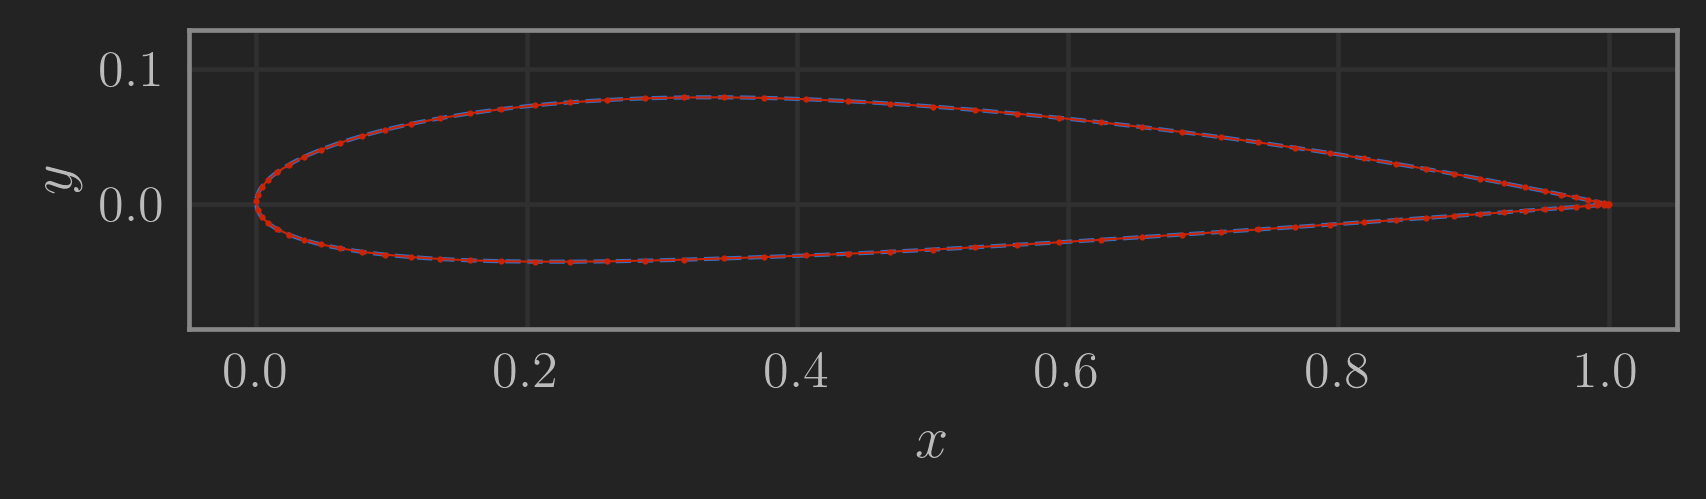

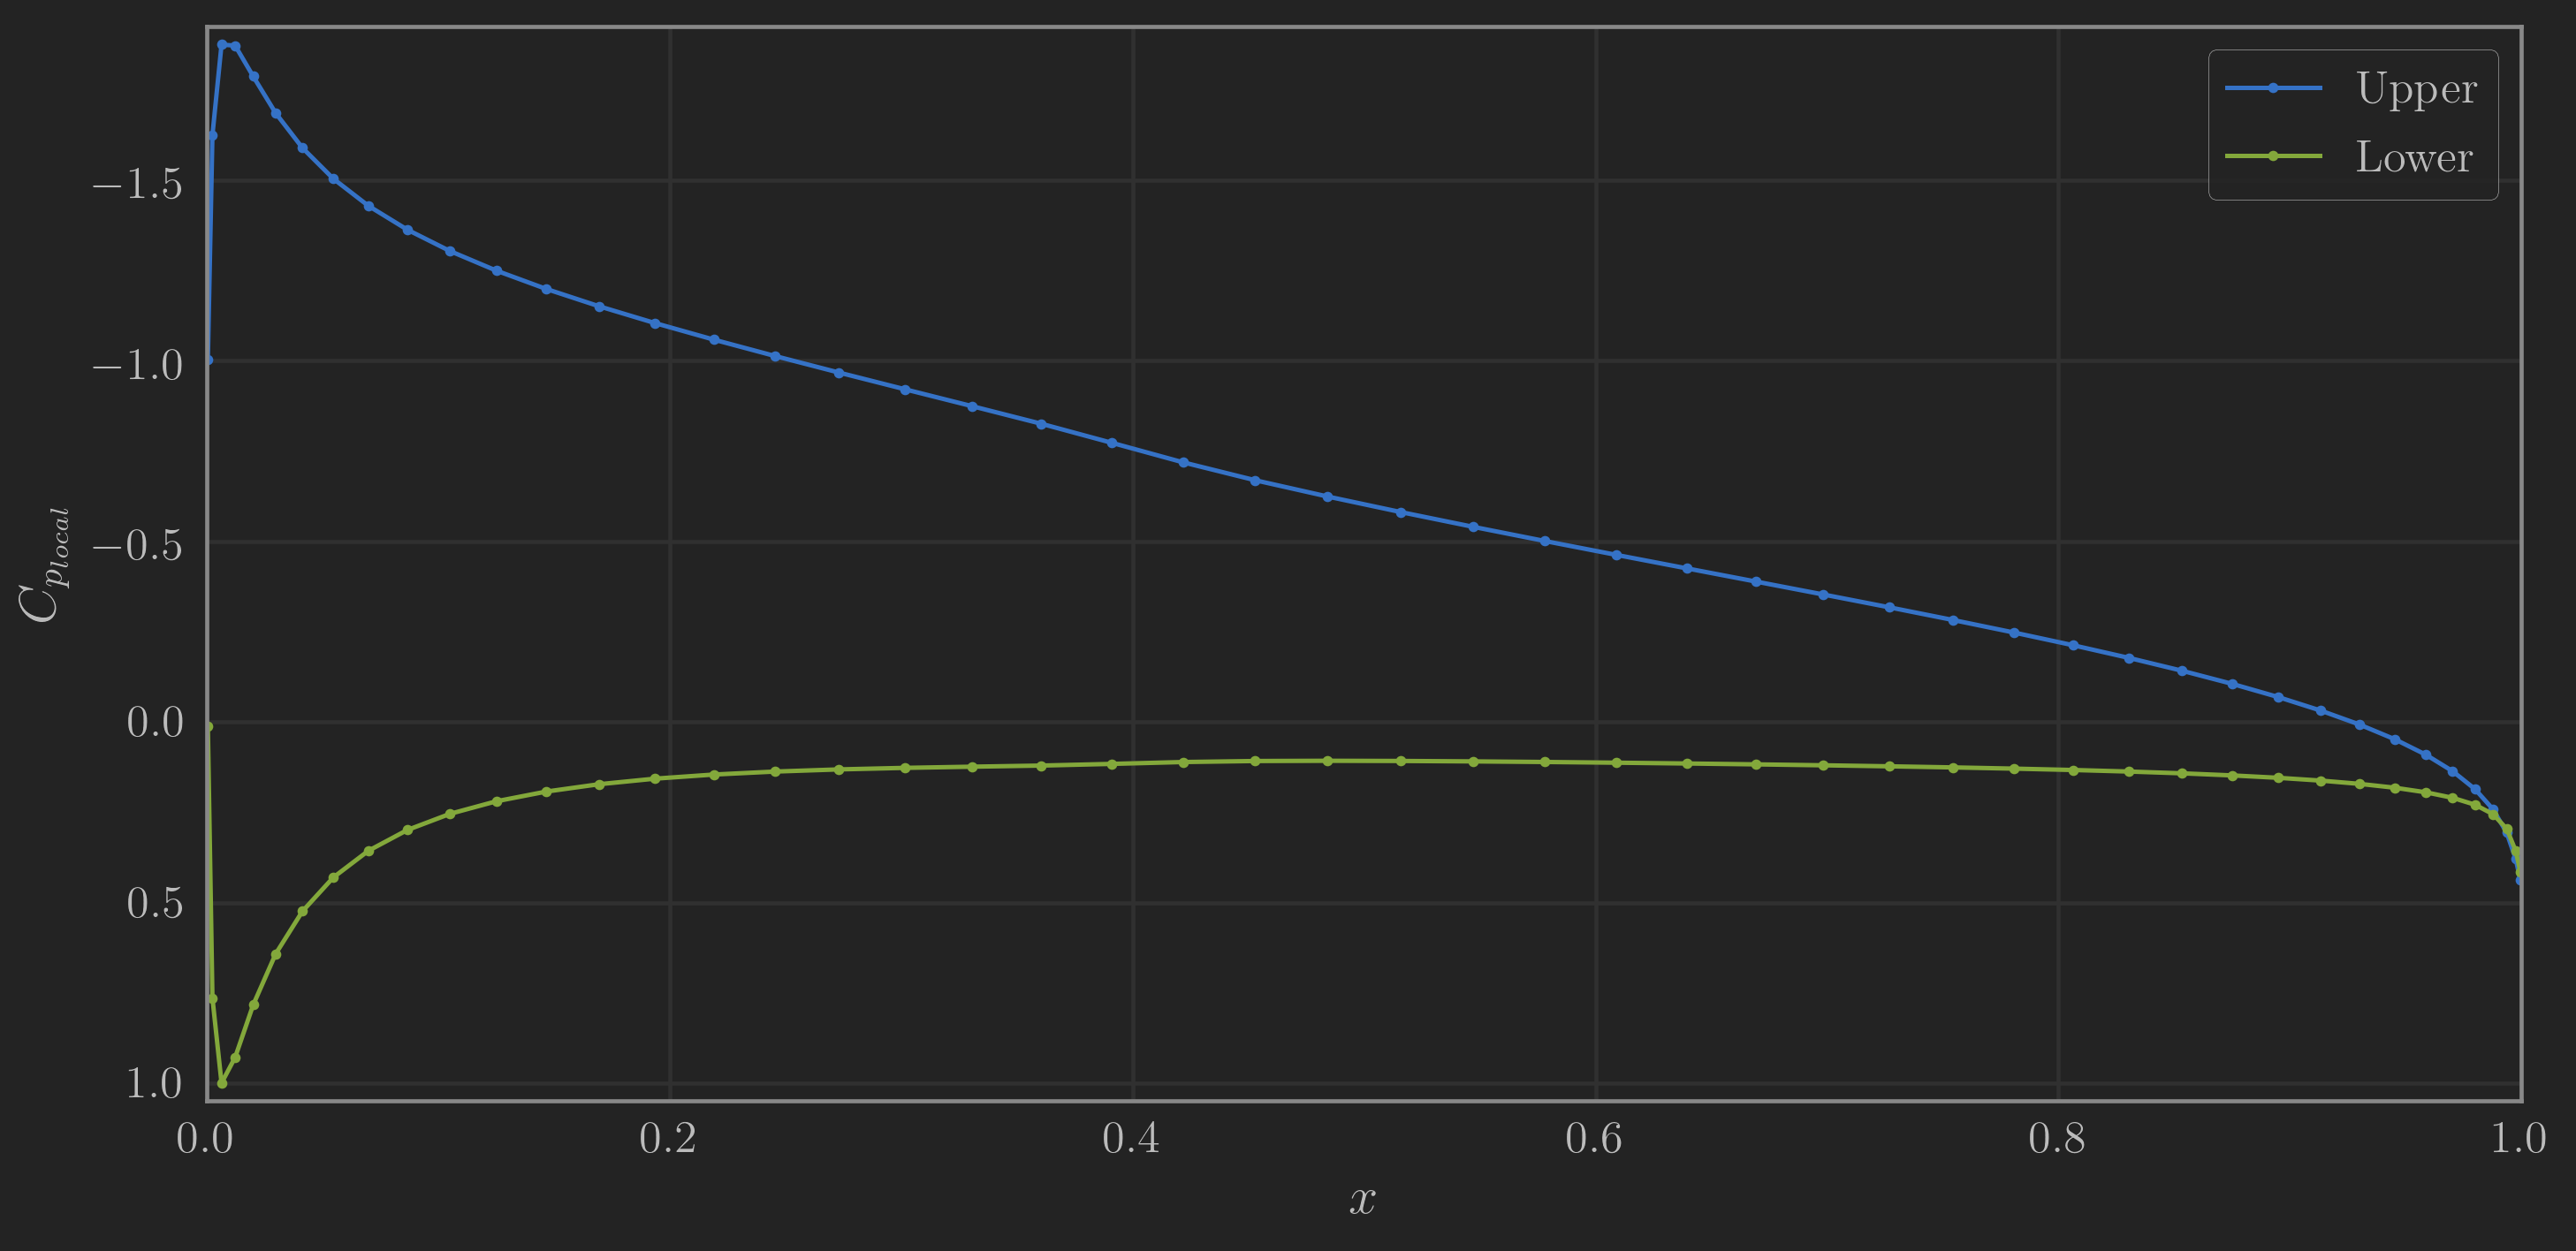

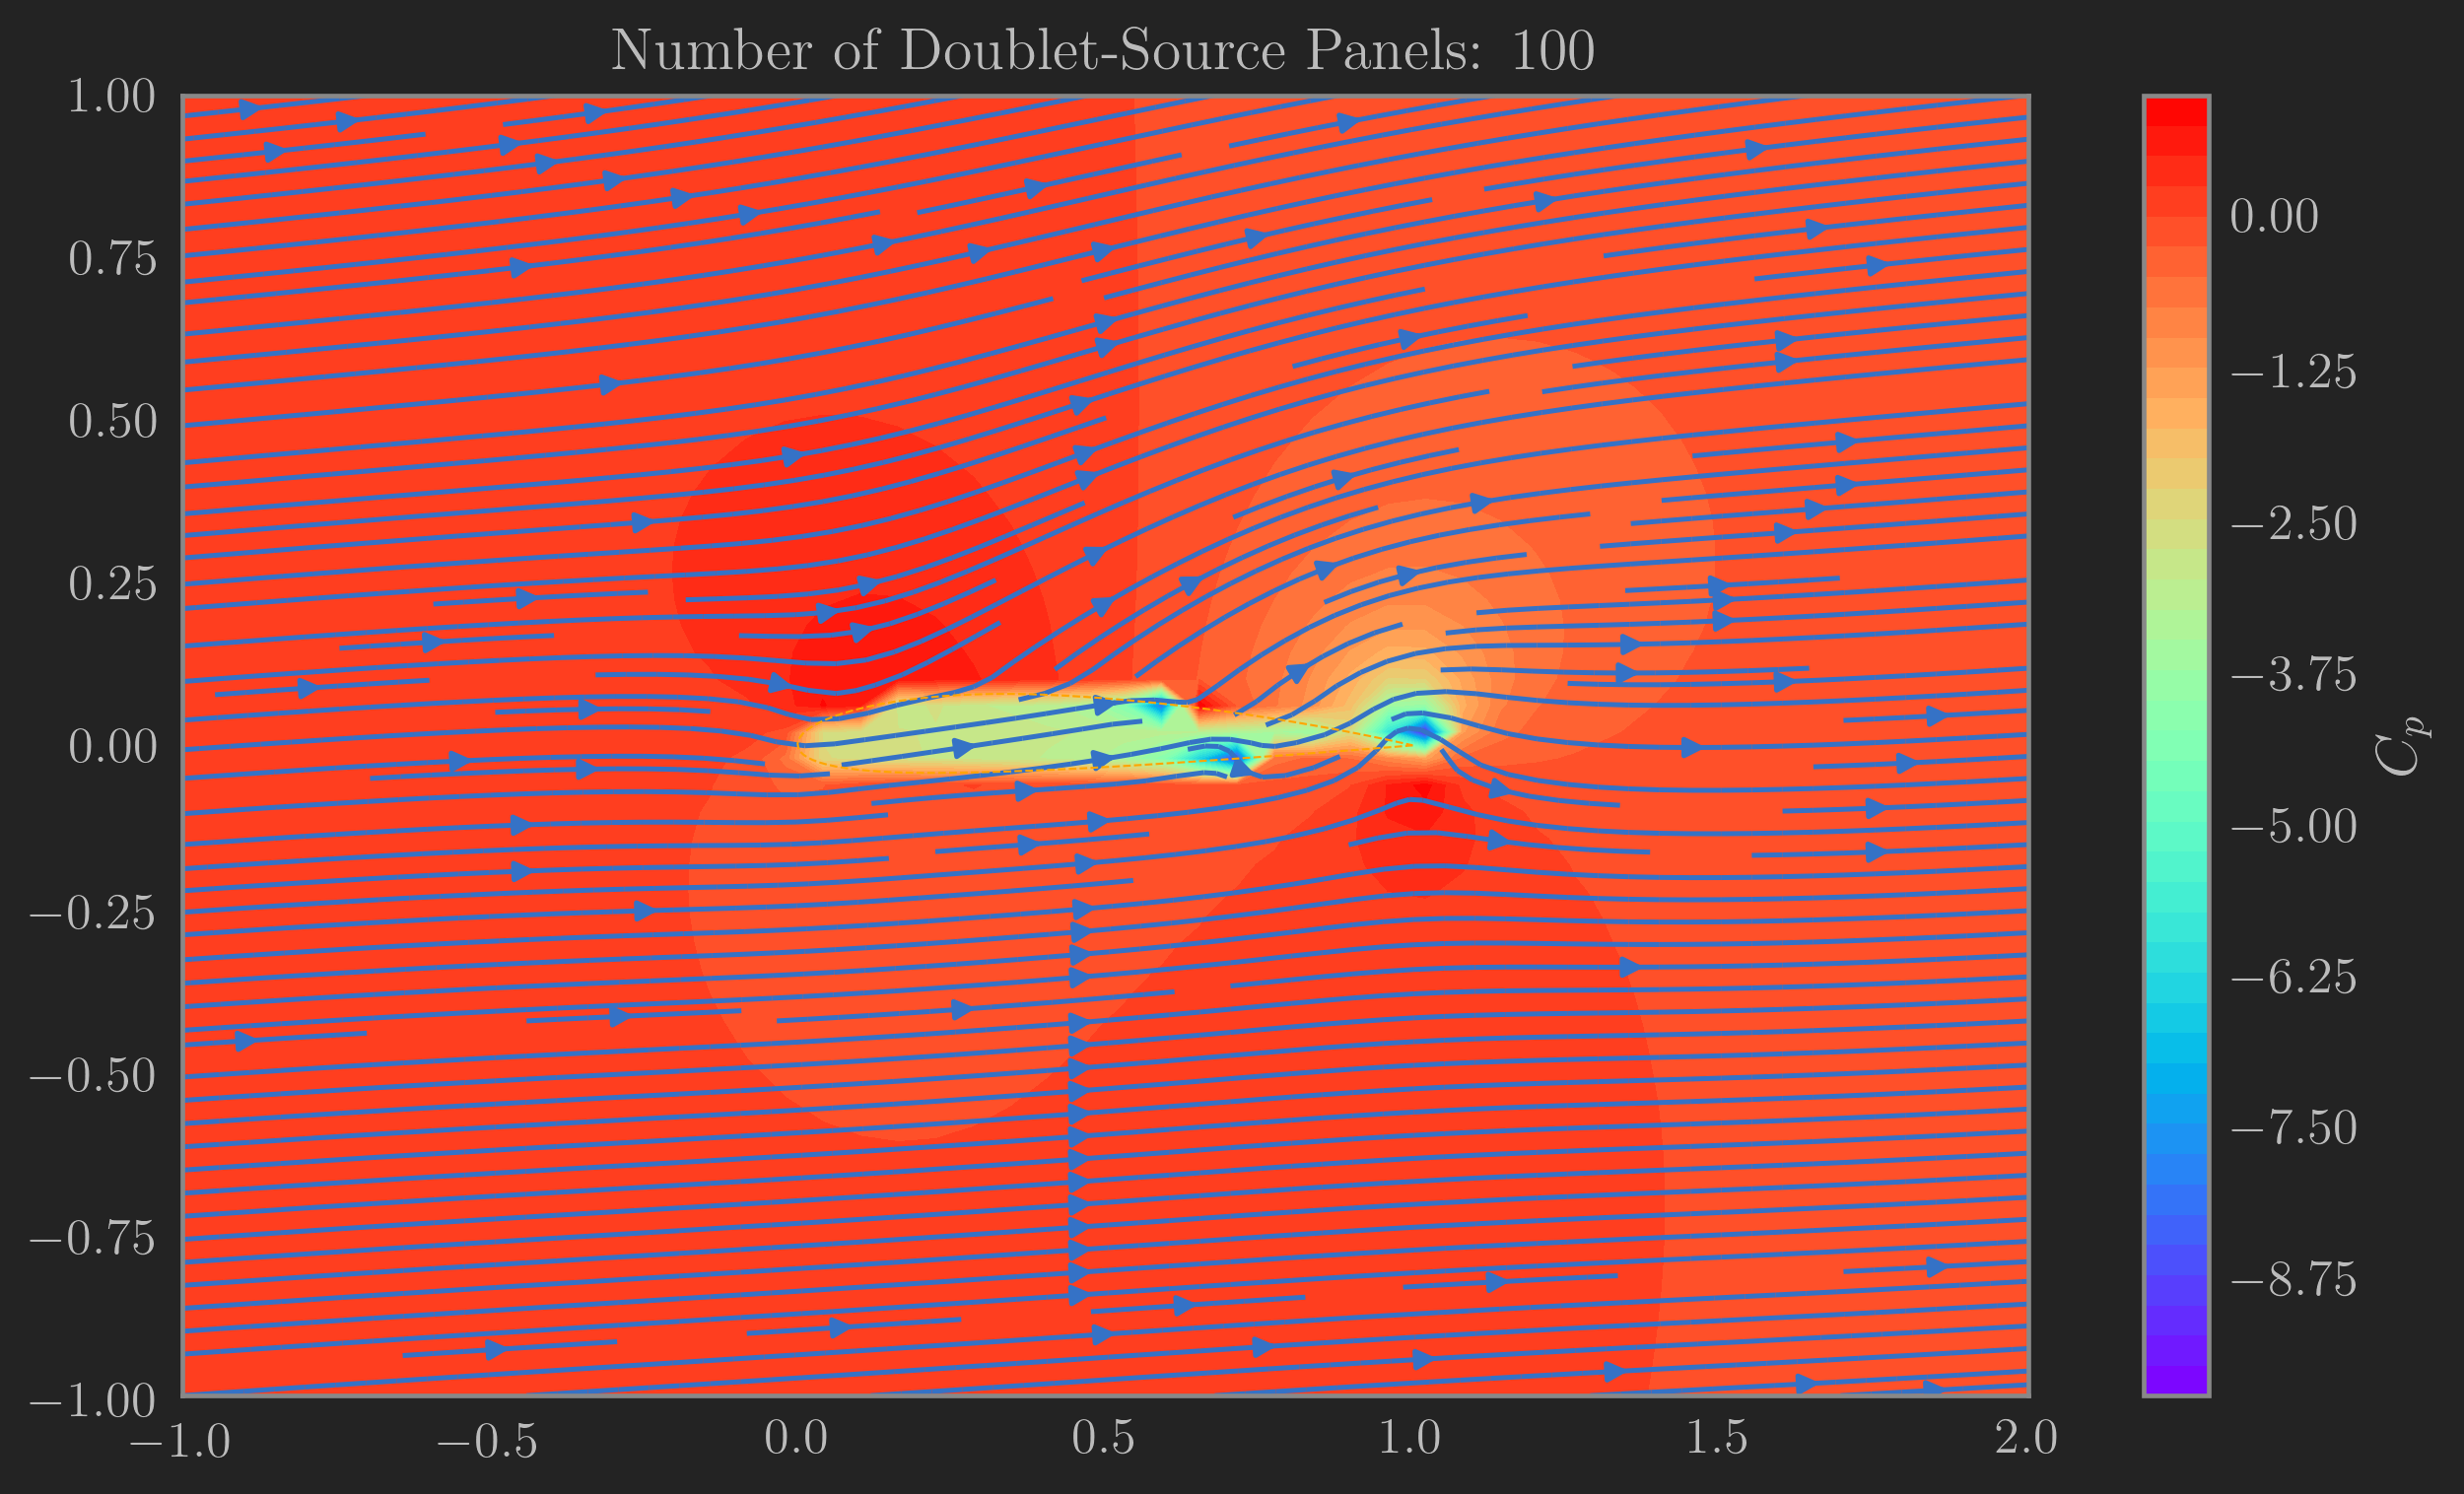

In [5]:
# Airfoil plotter
fig1 = figure(1, dpi=300)
xlabel("\$x\$")
ylabel("\$y\$")
plot([ x for (x,y) in coords], [ y for (x,y) in coords ], linestyle="--", linewidth=1)
plot([ panel.xs for panel in panels ], [ panel.ys for panel in panels ], linestyle="-", linewidth=0.5, marker=".", markersize=3, color="#CD2305")
axis("scaled", adjustable="box")
# xlim(-0.02,0.02)
ylim(minimum([ y for (x,y) in coords ]) - 0.05, maximum([ y for (x,y) in coords ]) + 0.05)
grid()

# Plot pressure coefficient
fig2 = figure(2, figsize=(10, 5), dpi=300)
grid()
plot([p.xc for p in panels if p.loc == "upper" ], [p.cp for p in panels if p.loc == "upper" ], marker=".", label="Upper")
plot([p.xc for p in panels if p.loc == "lower" ], [p.cp for p in panels if p.loc == "lower" ], marker=".", label="Lower")
xlabel("\$x\$")
ylabel("\$C_{p_{local}}\$")
xlim(0, 1.0)
ylim(-2,2)
ylim(maximum([p.cp for p in panels]) + 0.05, minimum([p.cp for p in panels]) - 0.05)
tight_layout()
legend()
show()

# Plot flowfield
width = 8.0
height = (y_domain[2] - y_domain[1]) / (x_domain[2] - x_domain[1]) * width
fig3 = figure(3, figsize=(1.1width, height), dpi=300)
streamplot(X, Y, first.(vels), last.(vels), density=2)
# scatter([p.xc for p in source_panels], [p.yc for p in source_panels], marker=".", label="Center-points", color="white", zorder=3)
contourf(X, Y, cp, 50, cmap=PyPlot.cm.rainbow)
# colorbar(label="\$\\phi_{\\mathrm{panel}}\$")
colorbar(label="\$C_p\$")
# fill([x for (x,y) in coords], [y for (x,y) in coords], color="k", zorder=3)
plot([p.xs for p in panels], [p.ys for p in panels], linestyle="--", linewidth=0.5, label="Endpoints", color="orange", zorder=3)
xlim(x_domain)
ylim(y_domain)
title("Number of Doublet-Source Panels: {$N_panels}")
tight_layout();